<a href="https://colab.research.google.com/github/Muhammad-Taufiq-Khan/Vision-Blood-Cancer-Stage-Detection/blob/main/notebooks/MobileNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Install Dependencies

In [20]:
import os 
import math
import shutil 
import glob
import keras
import numpy as np
from tensorflow.keras.utils import load_img, img_to_array
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Flatten, Dense
from keras.models import Model, load_model
from keras.applications.mobilenet import MobileNet, preprocess_input
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import load_model
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

# 1. Fetch dataset from kaggle

In [21]:
! pip install kaggle
! mkdir ~/.kaggle 
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download mehradaria/leukemia # Download Dataset
! unzip leukemia.zip # Unzip

The syntax of the command is incorrect.
'cp' is not recognized as an internal or external command,
operable program or batch file.
'chmod' is not recognized as an internal or external command,
operable program or batch file.
Traceback (most recent call last):
  File "C:\Users\User\anaconda3\envs\Project\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\Users\User\anaconda3\envs\Project\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "C:\Users\User\anaconda3\envs\Project\Scripts\kaggle.exe\__main__.py", line 4, in <module>
  File "C:\Users\User\anaconda3\envs\Project\lib\site-packages\kaggle\__init__.py", line 23, in <module>
    api.authenticate()
  File "C:\Users\User\anaconda3\envs\Project\lib\site-packages\kaggle\api\kaggle_api_extended.py", line 403, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in C:\Users\U

In [22]:
# Count the number of images in the respective classes
def ClassFreq(ROOT_DIR):
  number_of_images = {}
  for dir in os.listdir(ROOT_DIR):
    number_of_images[dir] = len(os.listdir(os.path.join(ROOT_DIR, dir))) # os.listdir() returns the elements on the specific folder
  print(number_of_images.items())

ClassFreq(r"C:\Users\User\Documents\Python Projects\Blood Cancer Detection\Code\Dataset\Original")

dict_items([('Benign', 124), ('Early', 227), ('Pre', 222), ('Pro', 188)])


# 3. Split Dataset

In [23]:
ROOT_DIR = r"C:\Users\User\Documents\Python Projects\Blood Cancer Detection\Code\Dataset\Original1"

def dataFolder(path, split):
  number_of_images = {}
  for dir in os.listdir(ROOT_DIR):
    number_of_images[dir] = len(os.listdir(os.path.join(ROOT_DIR, dir)))

  # Creates directory for train, test and validation set
  # Create separate folders for Training, Validation and Testing
  if not os.path.exists("./"+path): # When <path> directory is not available in the root directory
    os.mkdir("./"+path)             # make directory

    for dir in os.listdir(ROOT_DIR): #For the classes in the Root directory
      os.makedirs("./"+path+"/"+dir)      # create new directoris
      
      for img in np.random.choice(a = os.listdir(os.path.join(ROOT_DIR, dir)), size = (math.floor(split*number_of_images[dir])-5), replace = False):
        O = os.path.join(ROOT_DIR, dir, img)
        D = os.path.join("./"+path, dir)
        shutil.copy(O,D)
        os.remove(O)
        
  else:
    print(f"{path} directory already exists")

  print(f"{path} directory has been created")


#Split Dataset and create directory
dataFolder("train",0.7)
dataFolder("val",0.15)
dataFolder("test",0.15)

#Show data frequency
ClassFreq(r"C:\Users\User\Documents\Python Projects\Blood Cancer Detection\Code\Dataset\Original1\train")
ClassFreq(r"C:\Users\User\Documents\Python Projects\Blood Cancer Detection\Code\Dataset\Original1\val")
ClassFreq(r"C:\Users\User\Documents\Python Projects\Blood Cancer Detection\Code\Dataset\Original1\test")

train directory already exists
train directory has been created
val directory already exists
val directory has been created
test directory already exists
test directory has been created
dict_items([('Benign', 124), ('Early', 227), ('Pre', 222), ('Pro', 188)])
dict_items([('Benign', 36), ('Early', 36), ('Pre', 36), ('Pro', 36)])
dict_items([('Benign', 36), ('Early', 36), ('Pre', 36), ('Pro', 36)])


# 4. Preprocessing Images

In [24]:
def preprocessingImages(path):
  """
  Input: path
  Output: Generated Data
  """
  image_data = ImageDataGenerator(zoom_range = 0.2, shear_range=0.2,preprocessing_function=preprocess_input, horizontal_flip=True)
  image = image_data.flow_from_directory(directory=path, target_size=(224,224), batch_size = 32,  class_mode= "categorical")
  train_step = image.n//32
  return image, train_step

In [25]:
def ScaleImages(path):
  """
  Input: path
  Output: Generated Data
  """
  image_data = ImageDataGenerator(preprocessing_function=preprocess_input)
  image = image_data.flow_from_directory(directory=path, target_size=(224,224), batch_size = 32, class_mode= "categorical")
  steps = image.n//32
  return image, steps

In [26]:
train_path = r"C:\Users\User\Documents\Python Projects\Blood Cancer Detection\Code\Dataset\Original1\train"
test_path = r"C:\Users\User\Documents\Python Projects\Blood Cancer Detection\Code\Dataset\Original1\test"
val_path = r"C:\Users\User\Documents\Python Projects\Blood Cancer Detection\Code\Dataset\Original1\val"

train_data, train_step = preprocessingImages(train_path)
val_data, val_steps = ScaleImages(val_path)
test_data, test_steps = ScaleImages(test_path)

train_data.class_indices
print(test_data.class_indices)
print(val_data.class_indices)

Found 761 images belonging to 4 classes.
Found 144 images belonging to 4 classes.
Found 144 images belonging to 4 classes.
{'Benign': 0, 'Early': 1, 'Pre': 2, 'Pro': 3}
{'Benign': 0, 'Early': 1, 'Pre': 2, 'Pro': 3}


# 5. Model Building 

In [27]:
# Downloading MobileNet model
base_model = MobileNet(input_shape=(224,224,3), include_top=False)

for layer in base_model.layers:
  layer.trainable = False

X= Flatten()(base_model.output)
X= Dense(units=4, activation="softmax")(X)
model = Model(base_model.input, X)
model.compile(optimizer="rmsprop", loss=keras.losses.categorical_crossentropy, metrics = ["accuracy"])

In [28]:
base_model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 112, 112, 32

 )                                                               
                                                                 
 conv_dw_8_bn (BatchNormali  (None, 14, 14, 512)       2048      
 zation)                                                         
                                                                 
 conv_dw_8_relu (ReLU)       (None, 14, 14, 512)       0         
                                                                 
 conv_pw_8 (Conv2D)          (None, 14, 14, 512)       262144    
                                                                 
 conv_pw_8_bn (BatchNormali  (None, 14, 14, 512)       2048      
 zation)                                                         
                                                                 
 conv_pw_8_relu (ReLU)       (None, 14, 14, 512)       0         
                                                                 
 conv_dw_9 (DepthwiseConv2D  (None, 14, 14, 512)       4608      
 )        

In [29]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 112, 112, 32)      128 

 )                                                               
                                                                 
 conv_dw_8_bn (BatchNormali  (None, 14, 14, 512)       2048      
 zation)                                                         
                                                                 
 conv_dw_8_relu (ReLU)       (None, 14, 14, 512)       0         
                                                                 
 conv_pw_8 (Conv2D)          (None, 14, 14, 512)       262144    
                                                                 
 conv_pw_8_bn (BatchNormali  (None, 14, 14, 512)       2048      
 zation)                                                         
                                                                 
 conv_pw_8_relu (ReLU)       (None, 14, 14, 512)       0         
                                                                 
 conv_dw_9 (DepthwiseConv2D  (None, 14, 14, 512)       4608      
 )        

# 6. Training and Validation

In [30]:
mc = ModelCheckpoint(filepath="bestmodel.h5", 
                     monitor="val_accuracy", 
                     verbose=1, 
                     save_best_only = True)

es = EarlyStopping(monitor="val_accuracy", 
                   min_delta=0.01, 
                   patience= 11, 
                   verbose=1)
cb = [mc,es]
hist = model.fit_generator(train_data,
                           steps_per_epoch=train_step,
                           epochs = 70,
                           validation_data = val_data,
                           validation_steps=val_steps,
                           callbacks=cb)

Epoch 1/70
23/23 [==============================] - ETA: 0s - loss: 5.8045 - accuracy: 0.6626
Epoch 1: val_accuracy improved from -inf to 0.89062, saving model to bestmodel.h5
23/23 [==============================] - 14s 556ms/step - loss: 5.8045 - accuracy: 0.6626 - val_loss: 0.4091 - val_accuracy: 0.8906
Epoch 2/70
23/23 [==============================] - ETA: 0s - loss: 1.5461 - accuracy: 0.8244
Epoch 2: val_accuracy improved from 0.89062 to 0.93750, saving model to bestmodel.h5
23/23 [==============================] - 12s 507ms/step - loss: 1.5461 - accuracy: 0.8244 - val_loss: 0.2889 - val_accuracy: 0.9375
Epoch 3/70
23/23 [==============================] - ETA: 0s - loss: 1.6236 - accuracy: 0.8669
Epoch 3: val_accuracy improved from 0.93750 to 0.98438, saving model to bestmodel.h5
23/23 [==============================] - 12s 507ms/step - loss: 1.6236 - accuracy: 0.8669 - val_loss: 0.0417 - val_accuracy: 0.9844
Epoch 4/70
23/23 [==============================] - ETA: 0s - loss: 1.

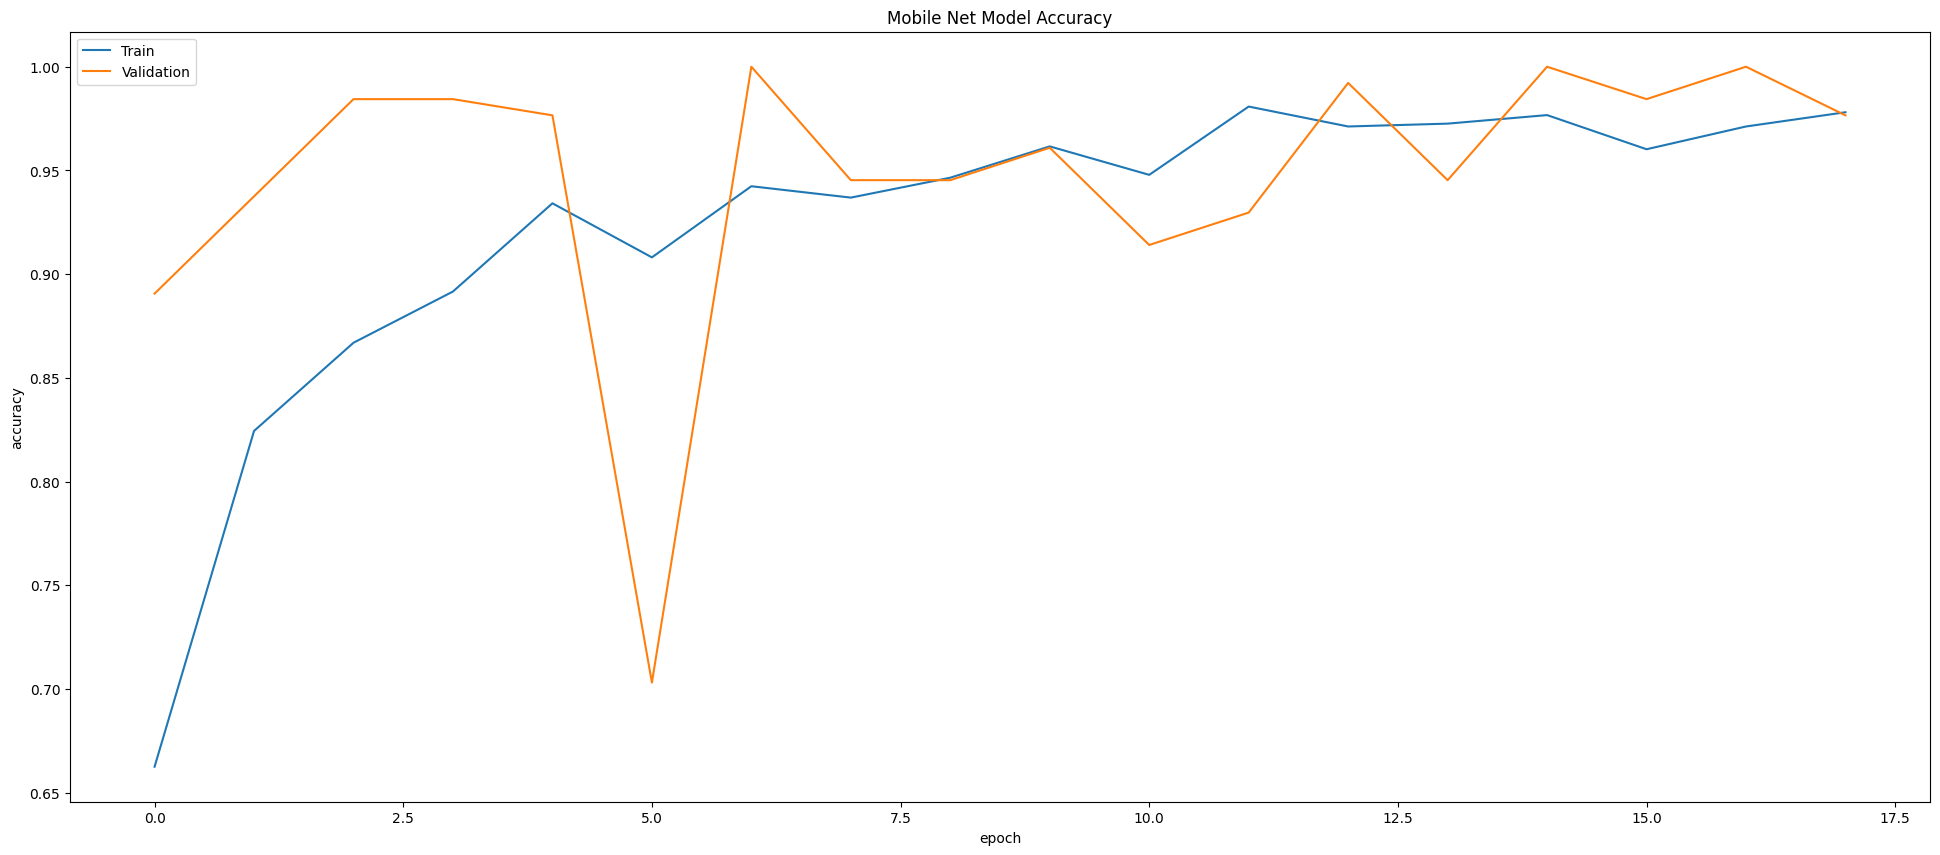

In [31]:
# summarize history for accuracy --- SAVE
plt.figure(figsize=(24, 10))
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Mobile Net Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig("MobileNet_Accuracy2.png")
plt.show()

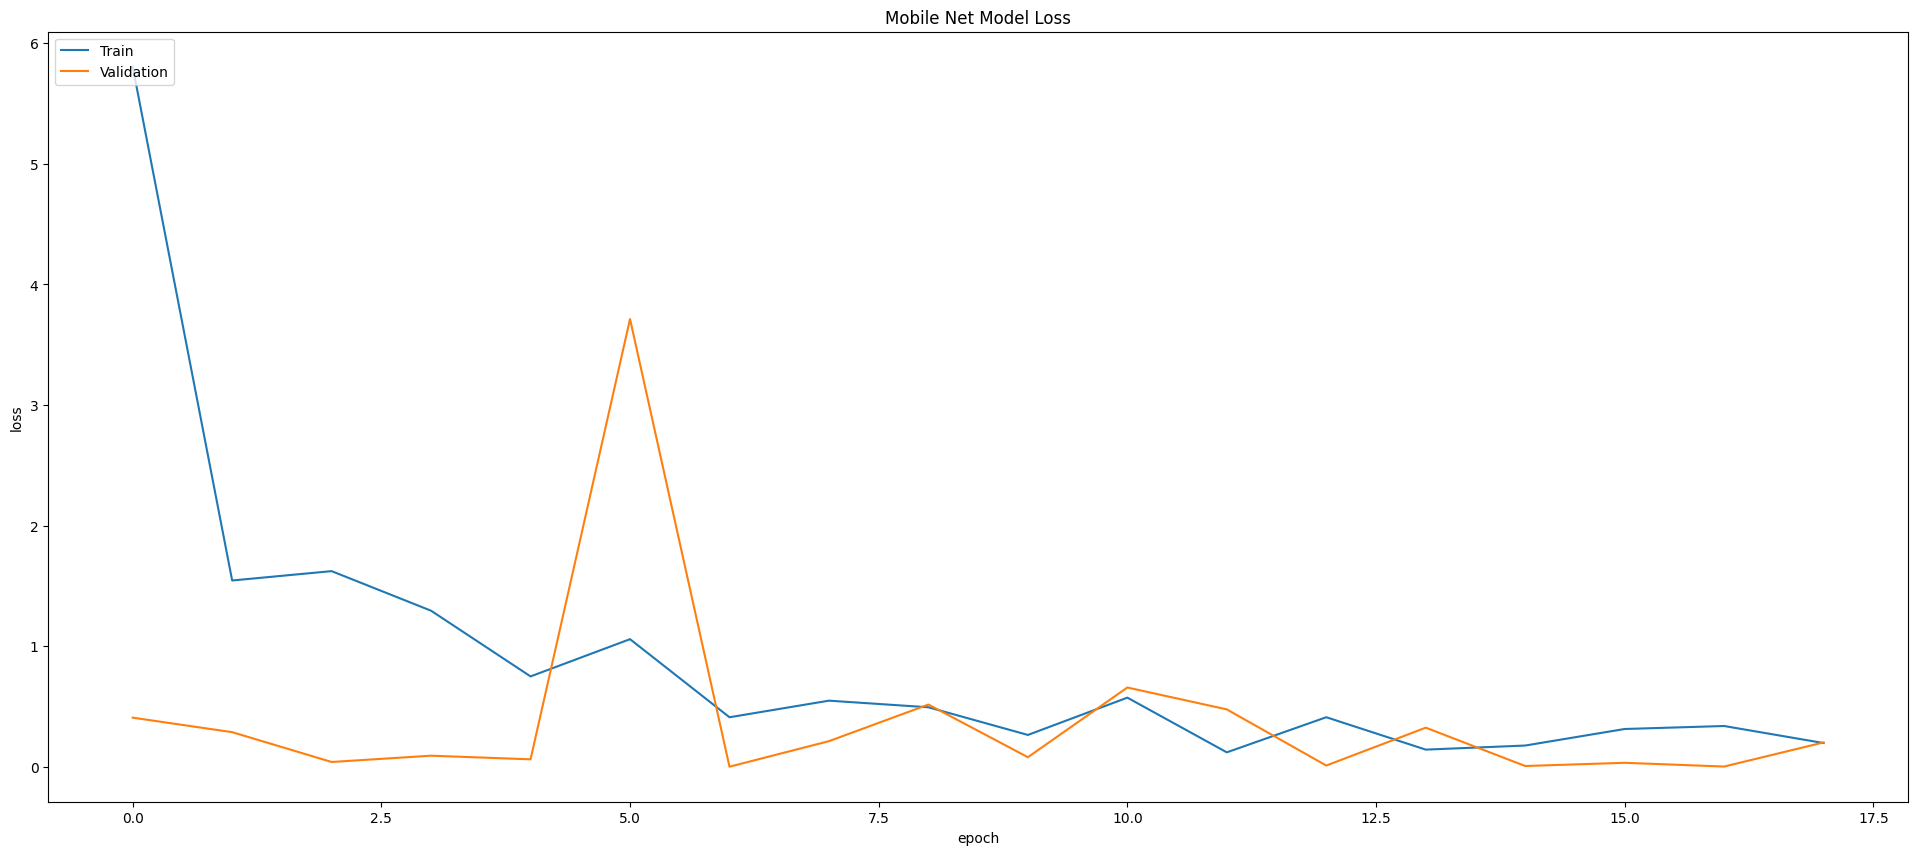

In [32]:
# summarize history for loss --- SAVE
plt.figure(figsize=(24, 10))
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Mobile Net Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig("MobileNet_Validation2.png")
plt.show()

# 8. Testing Model

5/5 [==============================] - 2s 299ms/step


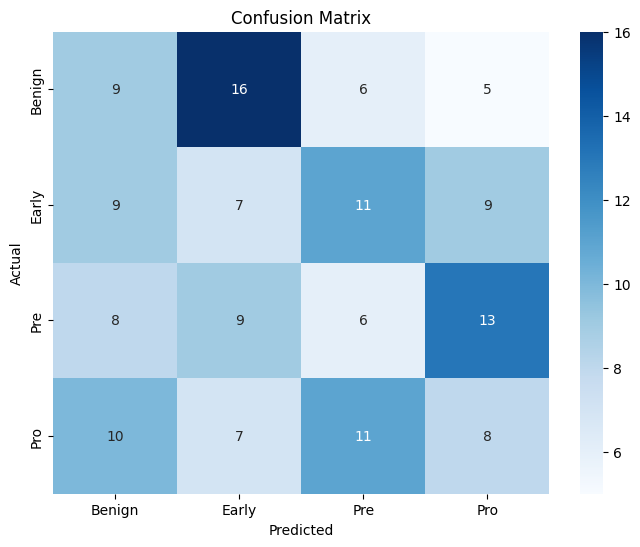

              precision    recall  f1-score   support

      Benign       0.25      0.25      0.25        36
       Early       0.18      0.19      0.19        36
         Pre       0.18      0.17      0.17        36
         Pro       0.23      0.22      0.23        36

    accuracy                           0.21       144
   macro avg       0.21      0.21      0.21       144
weighted avg       0.21      0.21      0.21       144



In [34]:

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Load the best model
best_model_path = r"C:\Users\User\Documents\Python Projects\Blood Cancer Detection\Code\models_dump\MobileNet_Model.h5"
model = load_model(best_model_path)

# Get predictions and true labels
y_true = test_data.classes  # True labels
y_pred_probs = model.predict(test_data)  # Predicted probabilities
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert to class labels

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_data.class_indices, yticklabels=test_data.class_indices)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Print classification report
print(classification_report(y_true, y_pred, target_names=test_data.class_indices.keys()))


# 9. Random Predict

1/1 [==============================] - 0s 32ms/step
Current stage: "Benign" and Class: 0



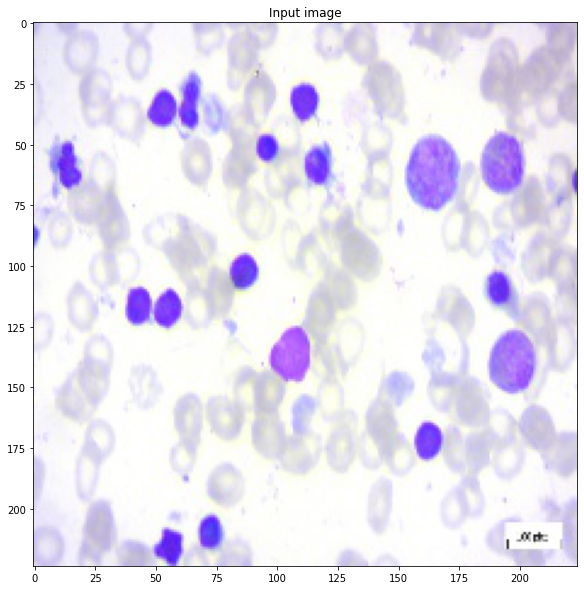

In [ ]:
# Random Check
def random_predict(path):
  img = load_img(path, target_size=(224,224))
  input_arr = img_to_array(img)/255
  input_arr = np.array([input_arr])
  
  # print(input_arr.shape)
  pred = np.argmax(model.predict(input_arr))
  if pred == 0:
    print(f'Current stage: "Benign" and Class: {pred}')
  elif pred == 1:
    print(f'Current stage: "Early" and Class: {pred}')
  elif pred == 2:
    print(f'Current stage: "Pre-B" and Class: {pred}')
  elif pred == 3:
    print(f'Current stage: "Pro-B" and Class: {pred}')
  else: print('unrecognized')
  print()

  plt.figure(figsize=(24, 10))
  plt.imshow(input_arr[0])
  # To display the image
  plt.title("Input image")
  plt.show()


# path = "/content/test/Early/WBC-Malignant-Early-123.jpg"
path = "/content/test/Benign/WBC-Benign-185.jpg"
random_predict(path)

In [ ]:
# convert notebook to html
! pip install nbconvert
! jupyter nbconvert --to html ALL_Cancer_Stage_Detection_using_MobileNet.ipynb


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
[NbConvertApp] Converting notebook ALL_Cancer_Stage_Detection_using_MobileNet.ipynb to html
[NbConvertApp] Writing 1163029 bytes to ALL_Cancer_Stage_Detection_using_MobileNet.html
